XGBoost model for predicting filtered shear stress, Time to next event (TTF) and Slip rate. 

(Multioutput Regression) 

In [8]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
from sklearn import multioutput
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Load the data

data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/p5270MechData/p5270MechData.mat')

a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'A_filt':data1['A_filt'].ravel(), 'V_filt':data1['V_filt'].ravel(),
                    'T_pc':data1['T_pc'].ravel(), 'Vel_pc':data1['Vel_pc'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel(), 'TTF':data1['TTF'].ravel()}) 

slip_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel()})

'''
df = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'ShearStress':data['ShearStress'].ravel(), 'LP2':data['LP2'].ravel(), 'LPDisp':data['LPDisp'].ravel(),
                   'LP_EC': data['LP_EC'].ravel(), 'Mu':data['Mu'].ravel(), 'ND_EC':data['ND_EC'].ravel(), 'NormDisp':data['NormDisp'].ravel(),
                   'NormStress': data['NormStress'].ravel(), 'OB':data['OB'].ravel(), 'SampleNum':data['SampleNum'].ravel(),
                   'Sample_Freq':data['Sample_Freq'].ravel(), 'Sync':data['Sync'].ravel(), 'Thickness':data['Thickness'].ravel(), 'V':data['V'].ravel()})
'''
df = a_t.merge(m_t, on='Time')
df = df.merge(slip_t, on='Time')

df = df.drop(['Time'], axis=1)

xdf = df[['A_filt', 'V_filt', 'T_pc', 'Vel_pc']]
ydf = df[['SS', 'TTF', 'V']]
print("Features:\n", xdf)
print("Target variables:\n", ydf)


Features:
              A_filt       V_filt  T_pc  Vel_pc
0       1804.180000  5489.978529   0.0     0.0
1       1803.666667  5489.981454   0.0     0.0
2       1803.314286  5489.997639   0.0     0.0
3       1803.437500  5490.007016   0.0     0.0
4       1803.266667  5490.000189   0.0     0.0
...             ...          ...   ...     ...
132394  1784.250000  5459.380488   0.0     0.0
132395  1784.055556  5459.377762   0.0     0.0
132396  1783.837500  5459.388352   0.0     0.0
132397  1783.371429  5459.398820   0.0     0.0
132398  1781.433333  5459.399041   0.0     0.0

[132399 rows x 4 columns]
Target variables:
               SS  TTF          V
0       5.656166  0.0   6.321073
1       5.657157  0.0  -6.953180
2       5.658317  0.0   9.903014
3       5.659499  0.0  -4.424751
4       5.660404  0.0   1.896322
...          ...  ...        ...
132394  5.471059  0.0   6.953180
132395  5.474545  0.0   5.056858
132396  5.478286  0.0 -10.745823
132397  5.481751  0.0  20.227432
132398  5.484813

In [10]:
# Split into train-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.3, shuffle=False)   
print("Training:", np.shape(x_train))
print("Testing:", np.shape(x_test))


Training: (92679, 4)
Testing: (39720, 4)


In [11]:
# Train the model
model = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=1000, base_score=0.5, objective='reg:squarederror')
model = multioutput.MultiOutputRegressor(model)
model.fit(x_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=1000,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                           

In [12]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(x_train))

ss_train_r2 = r2_score(y_train['SS'], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(y_train['SS'], y_predTrain[0]))

ttf_train_r2 = r2_score(y_train['TTF'], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(y_train['TTF'], y_predTrain[1]))

v_train_r2 = r2_score(y_train['V'], y_predTrain[2])
v_train_rmse = np.sqrt(mean_squared_error(y_train['V'], y_predTrain[2]))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ss_test_r2 = r2_score(y_test['SS'], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test['SS'], y_predTest[0]))

ttf_test_r2 = r2_score(y_test['TTF'], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test['TTF'], y_predTest[1]))

v_test_r2 = r2_score(y_test['V'], y_predTest[2])
v_test_rmse = np.sqrt(mean_squared_error(y_test['V'], y_predTest[2]))

print('Shear Stress')
print('R2 score:', ss_train_r2, ss_test_r2, '\nRMSE:', ss_test_rmse, ss_test_rmse)
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_test_r2, '\nRMSE:', ttf_test_rmse, ttf_test_rmse)
print('\nSlip rate')
print('R2 score:', v_train_r2, v_test_r2, '\nRMSE:', v_test_rmse, v_test_rmse)


Shear Stress
R2 score: 0.9066450558384177 0.8547474002150341 
RMSE: 0.05548255320962311 0.05548255320962311

TTF
R2 score: 0.8771121723942786 0.776312634535077 
RMSE: 0.5431405538792216 0.5431405538792216

Slip rate
R2 score: 0.8170722681328831 0.09125056075091809 
RMSE: 72.64237033796887 72.64237033796887


Text(0.5, 1.0, 'Slip rate All Data plot')

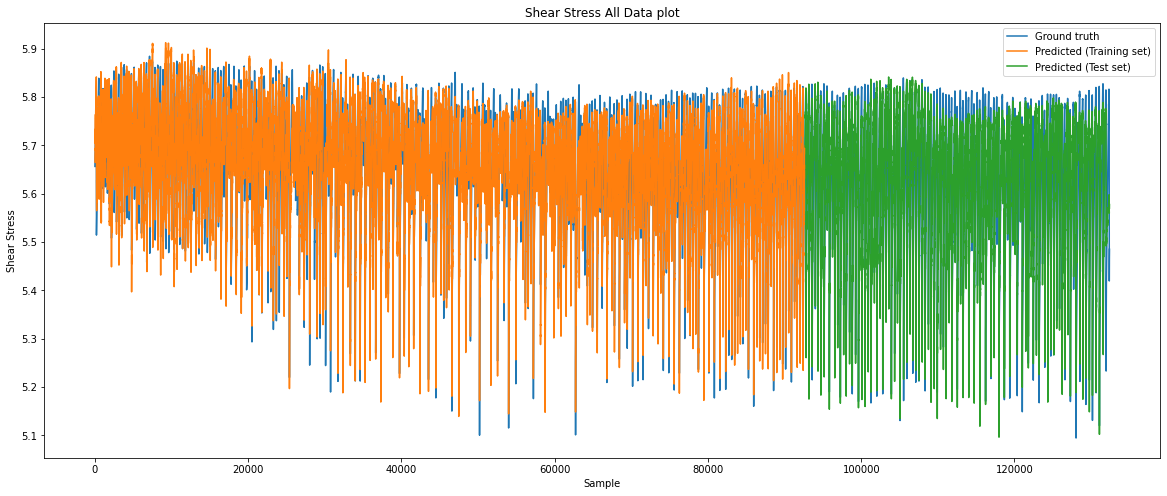

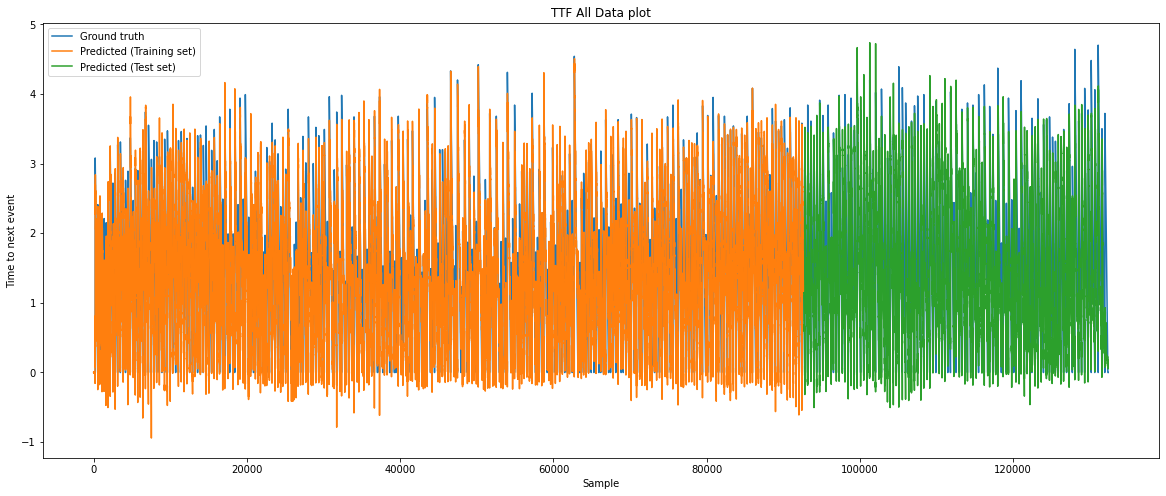

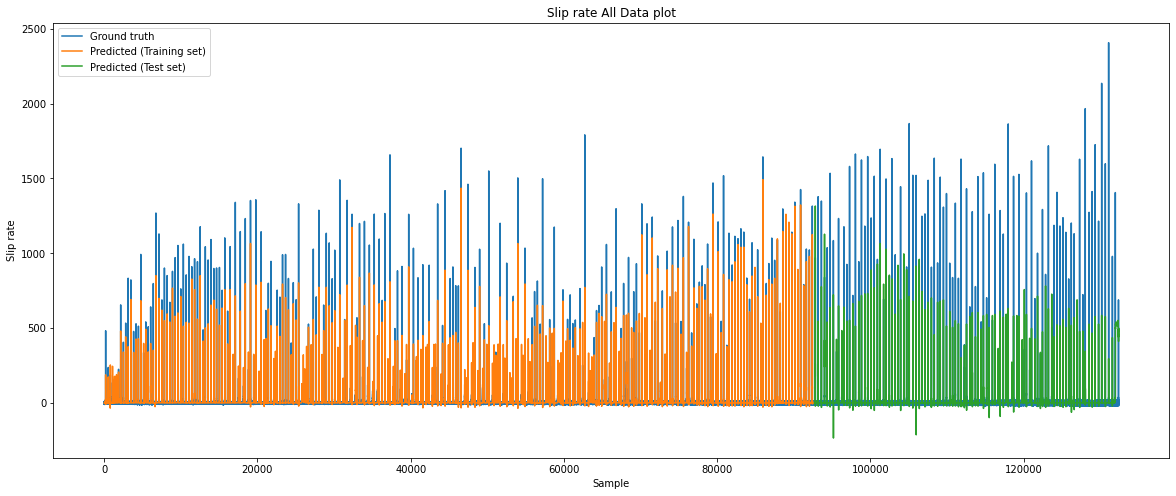

In [13]:
# Results plot

## SS plot
fig = plt.figure(1, figsize=(20,8))
plt.plot(ydf['SS'])
plt.plot(y_train.index, y_predTrain[0])
plt.plot(y_test.index, y_predTest[0])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted (Training set)', 'Predicted (Test set)'])
plt.title('Shear Stress All Data plot')

## TTF plot
fig = plt.figure(2, figsize=(20,8))
plt.plot(ydf['TTF'])
plt.plot(y_train.index, y_predTrain[1])
plt.plot(y_test.index, y_predTest[1])
plt.xlabel('Sample')
plt.ylabel('Time to next event')
plt.legend(['Ground truth', 'Predicted (Training set)', 'Predicted (Test set)'])
plt.title('TTF All Data plot')

## V plot
fig = plt.figure(3, figsize=(20,8))
plt.plot(ydf['V'])
plt.plot(y_train.index, y_predTrain[2])
plt.plot(y_test.index, y_predTest[2])
plt.xlabel('Sample')
plt.ylabel('Slip rate')
plt.legend(['Ground truth', 'Predicted (Training set)', 'Predicted (Test set)'])
plt.title('Slip rate All Data plot')


Text(0.5, 1.0, '5000 Samples, Test Data plot - Slip rate')

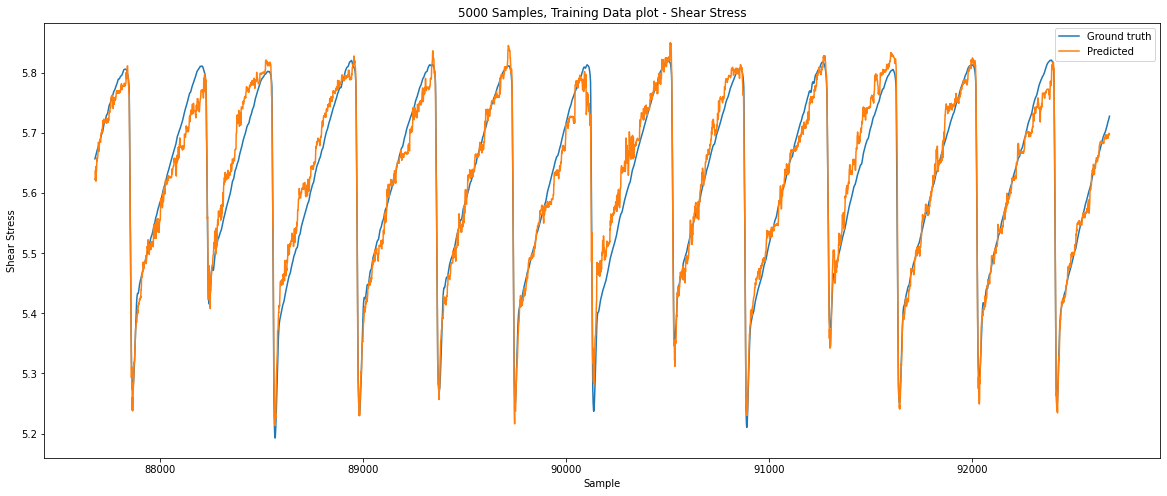

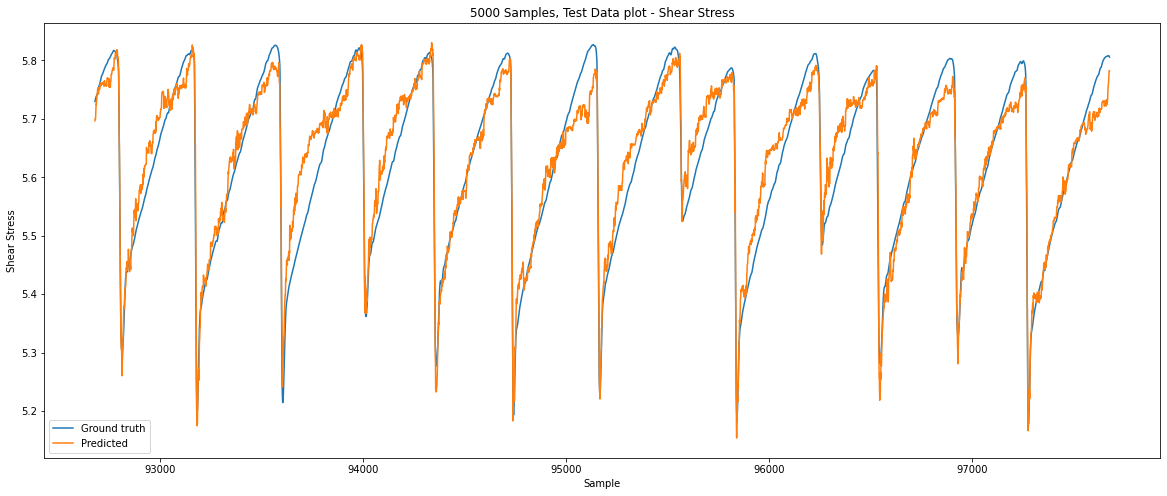

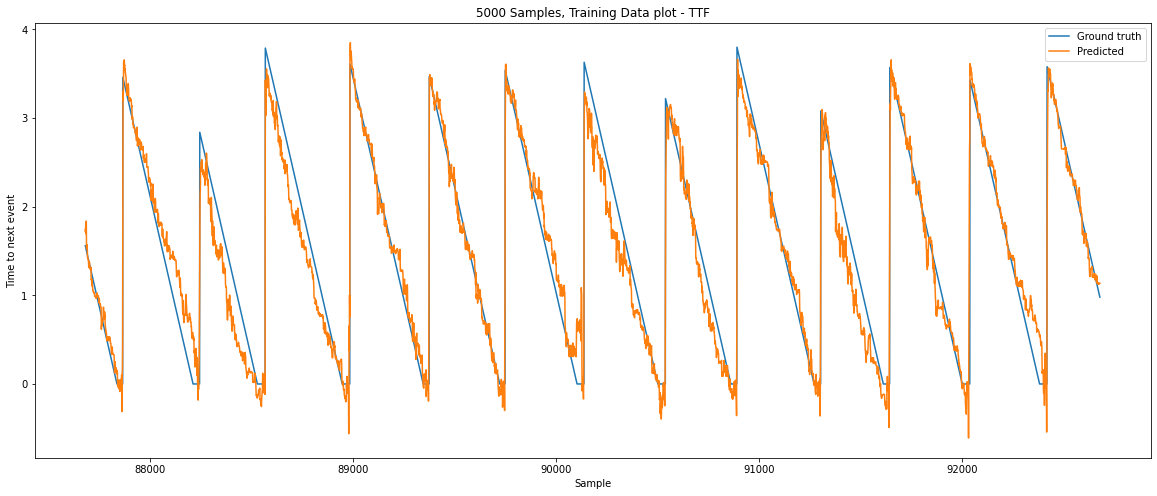

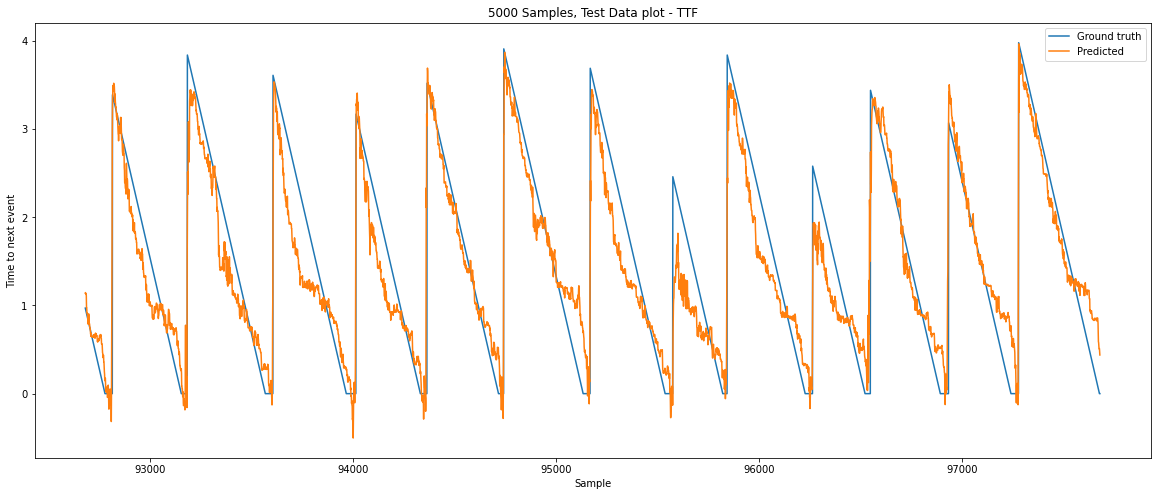

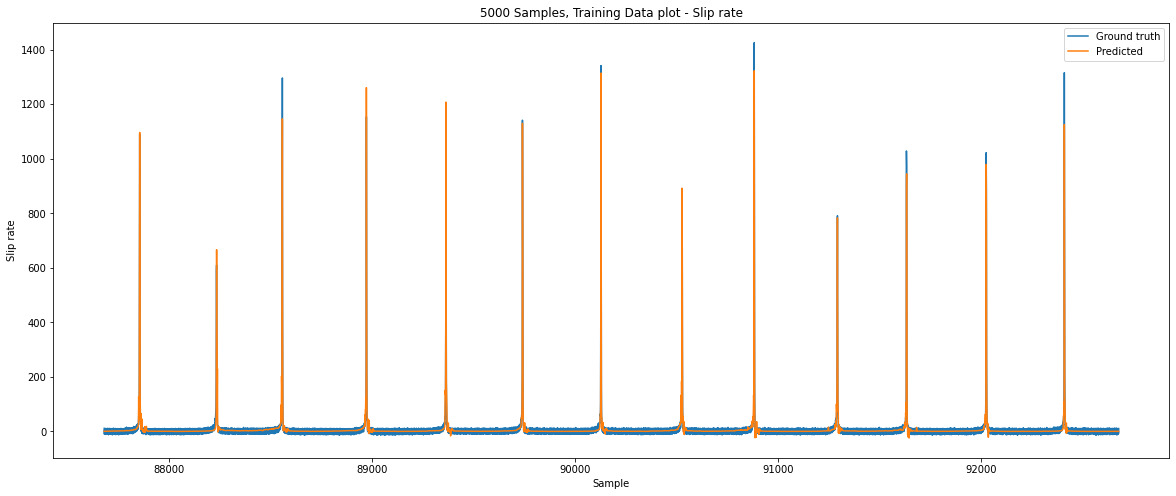

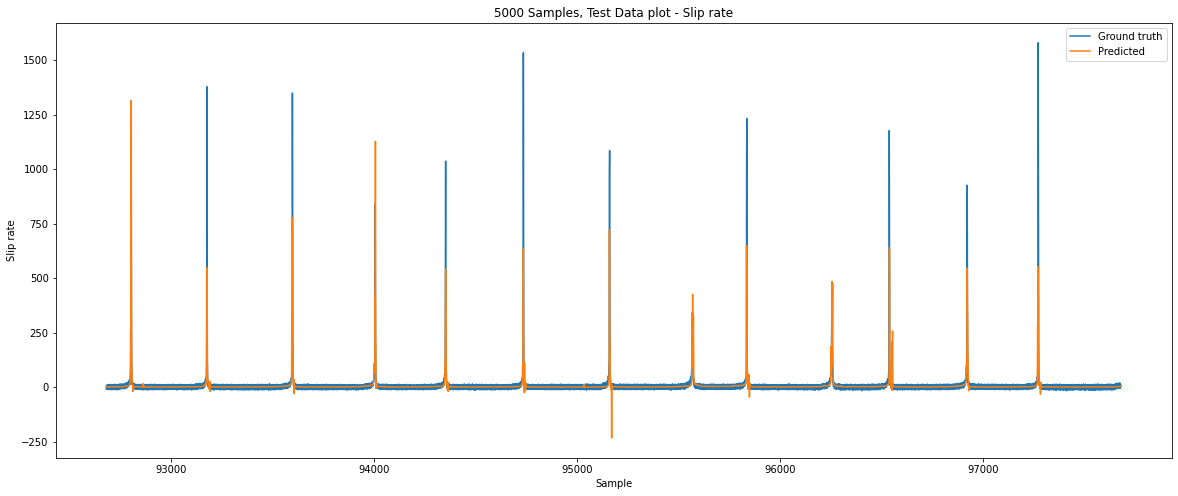

In [14]:
# Detailed view

n = 5000

## SS plot
fig = plt.figure(4, figsize=(20,8))
plt.plot(y_train.index[-n:], y_train['SS'][-n:])
plt.plot(y_train.index[-n:], y_predTrain[0][-n:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data plot - Shear Stress')

fig = plt.figure(5, figsize=(20,8))
plt.plot(y_test.index[:n], y_test['SS'][:n])
plt.plot(y_test.index[:n], y_predTest[0][:n])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Test Data plot - Shear Stress')

## TTF plot
fig = plt.figure(6, figsize=(20,8))
plt.plot(y_train.index[-n:], y_train['TTF'][-n:])
plt.plot(y_train.index[-n:], y_predTrain[1][-n:])
plt.xlabel('Sample')
plt.ylabel('Time to next event')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data plot - TTF')

fig = plt.figure(7, figsize=(20,8))
plt.plot(y_test.index[:n], y_test['TTF'][:n])
plt.plot(y_test.index[:n], y_predTest[1][:n])
plt.xlabel('Sample')
plt.ylabel('Time to next event')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Test Data plot - TTF')

## V plot
fig = plt.figure(8, figsize=(20,8))
plt.plot(y_train.index[-n:], y_train['V'][-n:])
plt.plot(y_train.index[-n:], y_predTrain[2][-n:])
plt.xlabel('Sample')
plt.ylabel('Slip rate')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data plot - Slip rate')

fig = plt.figure(9, figsize=(20,8))
plt.plot(y_test.index[:n], y_test['V'][:n])
plt.plot(y_test.index[:n], y_predTest[2][:n])
plt.xlabel('Sample')
plt.ylabel('Slip rate')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Test Data plot - Slip rate')
